In [1]:
!pip install yfinance

In [2]:
# --- Phase 1: Data Acquisition (PYPL) ---

import yfinance as yf
import pandas as pd
from datetime import date, timedelta

In [3]:
# 1. Define Scope
ticker = 'PYPL'
end_date = date.today()
# Calculate start date as 5 years ago from today
start_date = end_date - timedelta(days=5 * 365)

print(f"Fetching data for: {ticker}")
print(f"Timeframe: {start_date} to {end_date}")
print("---")

Fetching data for: PYPL
Timeframe: 2020-11-04 to 2025-11-03
---


In [4]:
# 2. Acquire Data
try:
    # yf.download() returns a pandas DataFrame
    data = yf.download(ticker, start=start_date, end=end_date)

    if data.empty:
        print(f"No data found for ticker {ticker}.")
        print("Please check the ticker symbol or the date range.")
    else:
        # Display the first 5 rows
        print("--- Data Head (First 5 Rows) ---")
        print(data.head())
        print("\n")

        # Display the last 5 rows
        print("--- Data Tail (Last 5 Rows) ---")
        print(data.tail())
        print("\n")

        # 3. Initial Data Inspection (for Phase 1, Step 3)
        # .info() is great for checking data types and, most importantly,
        # for spotting any missing values (NaNs).
        print("--- Data Info (Check for Missing Values) ---")
        data.info()

except Exception as e:
    print(f"An error occurred: {e}")

/tmp/ipython-input-1736179243.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

--- Data Head (First 5 Rows) ---
Price            Close        High         Low        Open    Volume
Ticker            PYPL        PYPL        PYPL        PYPL      PYPL
Date                                                                
2020-11-04  194.289993  195.000000  184.110001  186.759995  16107000
2020-11-05  204.559998  204.919998  199.369995  202.300003  15188500
2020-11-06  202.729996  204.919998  198.550003  204.600006   8075100
2020-11-09  184.720001  196.070007  184.440002  195.740005  18986400
2020-11-10  183.360001  186.710007  178.600006  184.979996  13144300


--- Data Tail (Last 5 Rows) ---
Price           Close       High        Low       Open    Volume
Ticker           PYPL       PYPL       PYPL       PYPL      PYPL
Date                                                            
2025-10-27  70.250000  71.870003  70.129997  70.855003  18821300
2025-10-28  73.019997  79.214996  72.830002  76.209999  83722300
2025-10-29  69.680000  72.730003  69.315002  72.699997  

--- Columns are already simple ---
--- Generating Close Price Plot ---
Saved plot to pypl_close_price.png


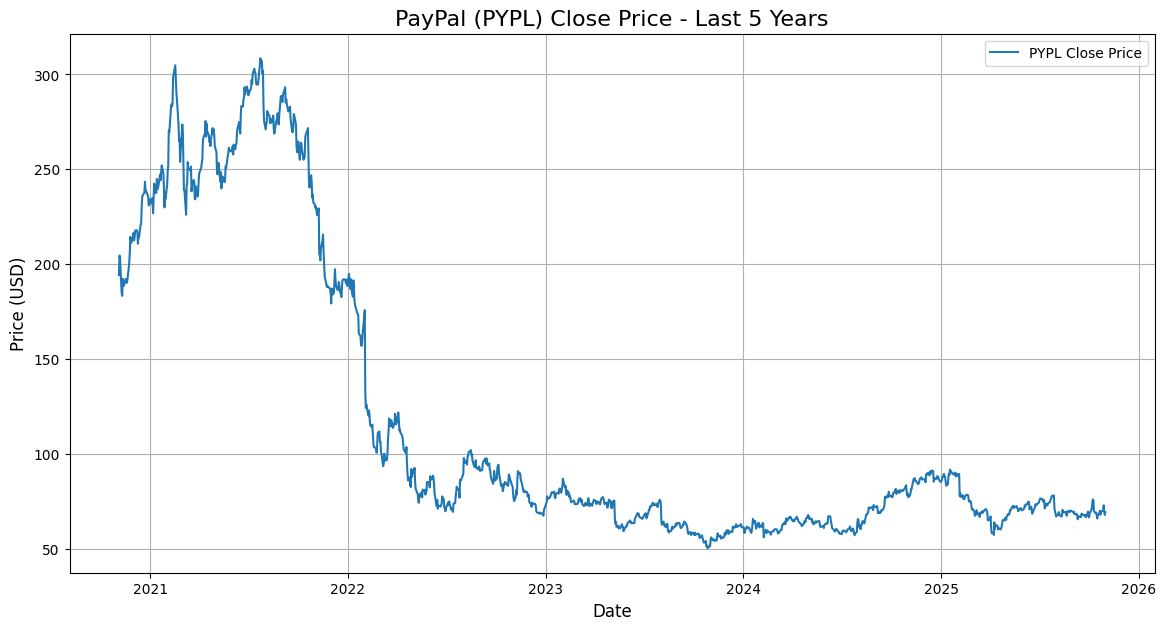

--- Generating Daily Returns Plot & Histogram ---
Saved plot to pypl_daily_returns.png


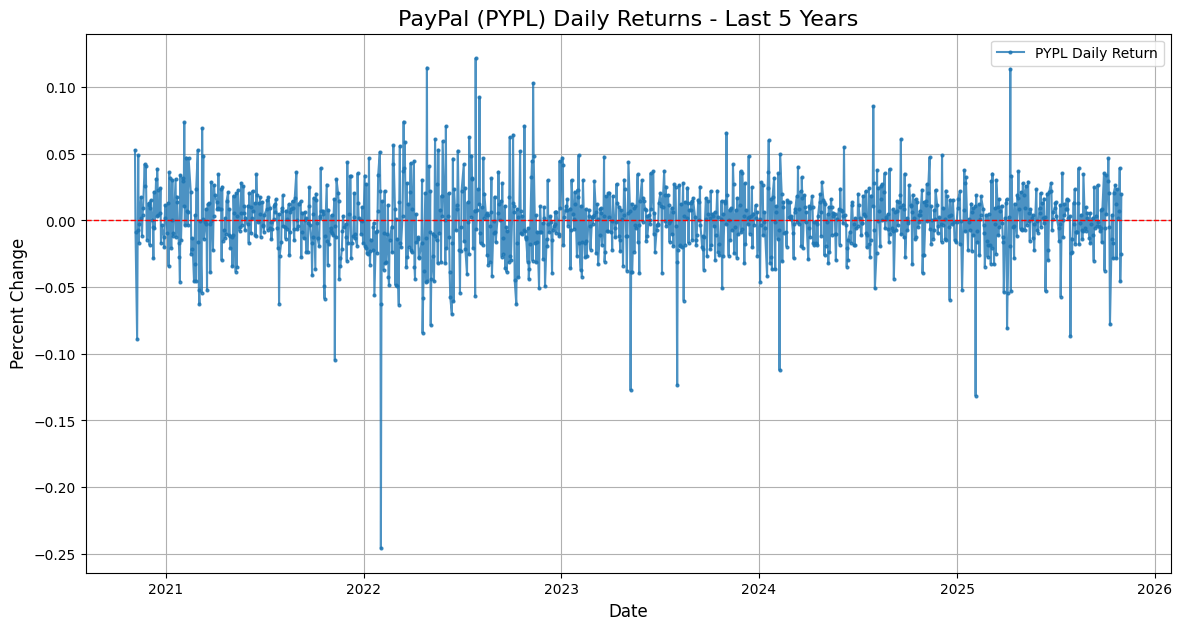

Saved plot to pypl_returns_histogram.png


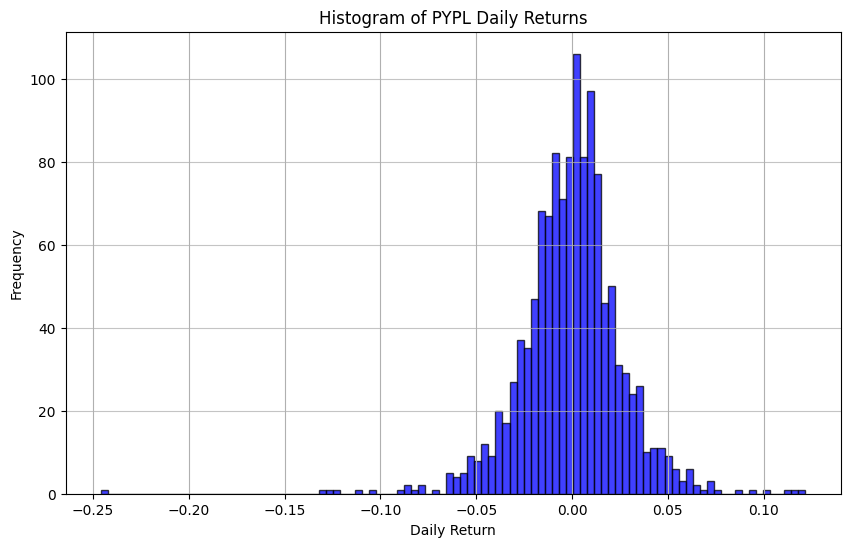

In [7]:
# --- Phase 1: Data Preprocessing & Phase 2: EDA ---

# (This code assumes 'data' is the DataFrame from the previous cell)

import matplotlib.pyplot as plt

# 1. Simplify Column Names (from MultiIndex)
# The columns are like ('Close', 'PYPL'). We just want 'Close'.
# We can drop the 'Ticker' level (level 1) of the columns.
try:
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.droplevel(1)
        print("--- Simplified Columns (Head) ---")
        print(data.head())
        print("\n")
    else:
        print("--- Columns are already simple ---")

    # 2. Select Target Variable
    # Our main target for forecasting is the 'Close' price.
    target_series = data['Close']

    # --- Phase 2: Exploratory Data Analysis (EDA) ---

    # 3. Visualize the Close Price (Phase 2, Step 1)
    # This plot helps us understand the long-term trend.
    print("--- Generating Close Price Plot ---")
    plt.figure(figsize=(14, 7))
    plt.plot(target_series.index, target_series, label='PYPL Close Price')
    plt.title('PayPal (PYPL) Close Price - Last 5 Years', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price (USD)', fontsize=12)
    plt.legend()
    plt.grid(True)

    # Save the plot to a file *before* showing it
    plt.savefig('pypl_close_price.png', dpi=300, bbox_inches='tight')
    print("Saved plot to pypl_close_price.png")

    # This will display the plot in your Colab notebook
    plt.show()


    # 4. Visualize Daily Returns (to see volatility)
    # Returns are stationary (they hover around 0), while price is not.
    # We calculate the percentage change from one day to the next.
    print("--- Generating Daily Returns Plot & Histogram ---")
    # We need to drop the first NaN value created by pct_change() for a clean plot
    data_returns = data['Daily_Return'].dropna()

    # Plot the daily returns over time
    plt.figure(figsize=(14, 7))
    plt.plot(data_returns.index, data_returns, label='PYPL Daily Return',
             alpha=0.8, linestyle='-', marker='o', markersize=2)
    plt.title('PayPal (PYPL) Daily Returns - Last 5 Years', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Percent Change', fontsize=12)
    plt.axhline(0, color='red', linestyle='--', linewidth=1) # Add a line at 0
    plt.legend()
    plt.grid(True)

    # Save the plot
    plt.savefig('pypl_daily_returns.png', dpi=300, bbox_inches='tight')
    print("Saved plot to pypl_daily_returns.png")

    plt.show()

    # Plot a histogram of the daily returns
    # This shows us the distribution of returns.
    plt.figure(figsize=(10, 6))
    data_returns.hist(bins=100, alpha=0.75, color='blue', edgecolor='black')
    plt.title('Histogram of PYPL Daily Returns')
    plt.xlabel('Daily Return')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)

    # Save the plot
    plt.savefig('pypl_returns_histogram.png', dpi=300, bbox_inches='tight')
    print("Saved plot to pypl_returns_histogram.png")

    plt.show()


except Exception as e:
    print(f"An error occurred: {e}")
    print("Make sure you have run the previous data acquisition cell.")



In [8]:
# --- Phase 2: Statistical Analysis (Step 2: Stationarity Test) ---

# We will use the Augmented Dickey-Fuller (ADF) test.
# Null Hypothesis (H0): The time series is non-stationary (it has a unit root).
# Alternative Hypothesis (H1): The time series is stationary.
# We want to REJECT the Null Hypothesis.

# How to interpret the result:
# If p-value <= 0.05: Reject H0 -> The series is STATIONARY.
# If p-value > 0.05:  Fail to reject H0 -> The series is NON-STATIONARY.

from statsmodels.tsa.stattools import adfuller

# (This code assumes 'data' is the DataFrame from the previous steps,
# and 'target_series' is data['Close'])

try:
    print("--- Running ADF Test on Close Price (Non-Stationary) ---")
    # We test the raw 'Close' price first. We expect this to be non-stationary.
    # We must drop any NaN values for the test to run
    adf_test_price = adfuller(target_series.dropna())

    print(f'ADF Statistic: {adf_test_price[0]}')
    print(f'p-value: {adf_test_price[1]}')
    print('Critical Values:')
    for key, value in adf_test_price[4].items():
        print(f'\t{key}: {value}')

    if adf_test_price[1] > 0.05:
        print("\nResult: p-value is > 0.05. We fail to reject H0.")
        print("Conclusion: The Close Price series is NON-STATIONARY (as expected).")
    else:
        print("\nResult: p-value is <= 0.05. We reject H0.")
        print("Conclusion: The Close Price series is STATIONARY (unexpected).")


    print("\n" + "="*50 + "\n")


    print("--- Running ADF Test on Daily Returns (Stationary) ---")
    # Now we test the 'Daily_Return'. We expect this to be stationary.
    # .dropna() is crucial here as the first day's return is NaN
    daily_returns = data['Daily_Return'].dropna()
    adf_test_returns = adfuller(daily_returns)

    print(f'ADF Statistic: {adf_test_returns[0]}')
    print(f'p-value: {adf_test_returns[1]}')
    print('Critical Values:')
    for key, value in adf_test_returns[4].items():
        print(f'\t{key}: {value}')

    if adf_test_returns[1] > 0.05:
        print("\nResult: p-value is > 0.05. We fail to reject H0.")
        print("Conclusion: The Daily Returns series is NON-STATIONARY (unexpected).")
    else:
        print("\nResult: p-value is <= 0.05. We reject H0.")
        print("Conclusion: The Daily Returns series is STATIONARY (as expected).")

except ImportError:
    print("Error: 'statsmodels' library not found.")
    print("Please install it in Colab by running: !pip install statsmodels")
except Exception as e:
    print(f"An error occurred: {e}")


--- Running ADF Test on Close Price (Non-Stationary) ---
ADF Statistic: -1.1411494409281298
p-value: 0.6983862618216423
Critical Values:
	1%: -3.4355838322867998
	5%: -2.863851267837805
	10%: -2.5680005460145554

Result: p-value is > 0.05. We fail to reject H0.
Conclusion: The Close Price series is NON-STATIONARY (as expected).


--- Running ADF Test on Daily Returns (Stationary) ---
ADF Statistic: -35.20324405715617
p-value: 0.0
Critical Values:
	1%: -3.4355838322867998
	5%: -2.863851267837805
	10%: -2.5680005460145554

Result: p-value is <= 0.05. We reject H0.
Conclusion: The Daily Returns series is STATIONARY (as expected).


In [ ]:
# --- Phase 2: Statistical Analysis (Step 3: Autocorrelation Plots) ---

# We will plot the ACF and PACF for our STATIONARY series: 'Daily_Return'
# This helps us determine the parameters (p, q) for an ARIMA model.

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# (This code assumes 'data' is the DataFrame from the previous steps)

try:
    # Use the stationary daily returns, dropping the first NaN value
    daily_returns = data['Daily_Return'].dropna()

    print("--- Generating ACF (Autocorrelation) Plot ---")

    # Plot the ACF
    fig_acf, ax_acf = plt.subplots(figsize=(12, 6))
    plot_acf(daily_returns, lags=40, ax=ax_acf, title='Autocorrelation (ACF) - PYPL Daily Returns')
    ax_acf.set_xlabel('Lag')
    ax_acf.set_ylabel('Autocorrelation')

    # Save the plot
    plt.savefig('pypl_acf_plot.png', dpi=300, bbox_inches='tight')
    print("Saved plot to pypl_acf_plot.png")
    plt.show()


    print("\n--- Generating PACF (Partial Autocorrelation) Plot ---")

    # Plot the PACF
    fig_pacf, ax_pacf = plt.subplots(figsize=(12, 6))
    plot_pacf(daily_returns, lags=40, ax=ax_pacf, title='Partial Autocorrelation (PACF) - PYPL Daily Returns', method='ywm')
    ax_pacf.set_xlabel('Lag')
    ax_pacf.set_ylabel('Partial Autocorrelation')

    # Save the plot
    plt.savefig('pypl_pacf_plot.png', dpi=300, bbox_inches='tight')
    print("Saved plot to pypl_pacf_plot.png")
    plt.show()

except ImportError:
    print("Error: 'statsmodels' library not found.")
    print("Please install it in Colab by running: !pip install statsmodels")
except Exception as e:
    print(f"An error occurred: {e}")


--- Generating ACF (Autocorrelation) Plot ---
Saved plot to pypl_acf_plot.png


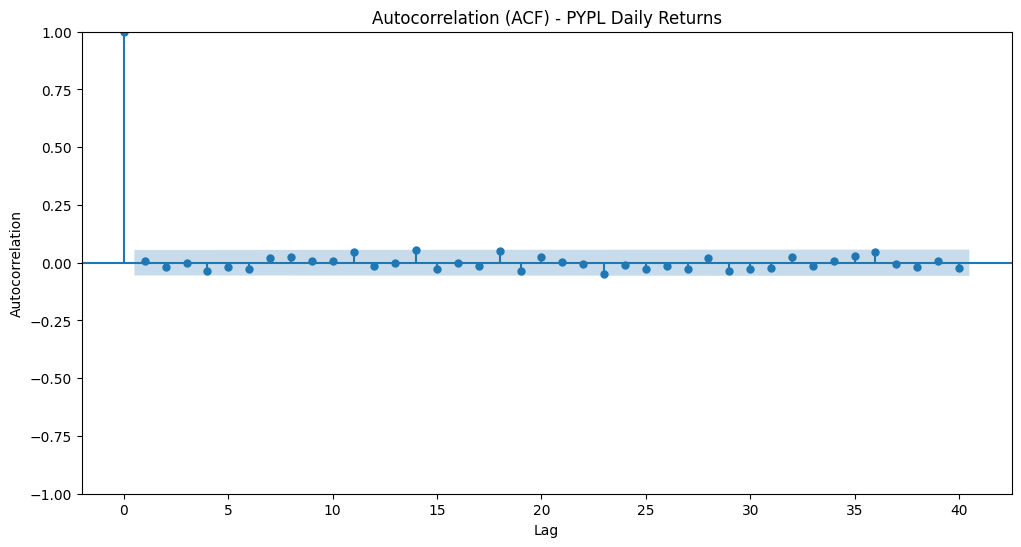


--- Generating PACF (Partial Autocorrelation) Plot ---
Saved plot to pypl_pacf_plot.png


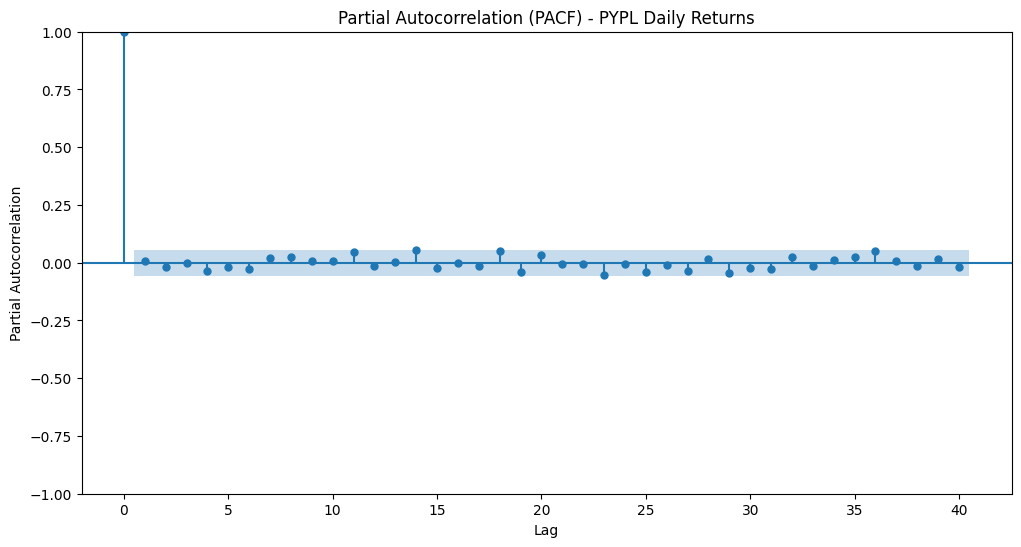

In [9]:
# --- Phase 2: Statistical Analysis (Step 3: Autocorrelation Plots) ---

# We will plot the ACF and PACF for our STATIONARY series: 'Daily_Return'
# This helps us determine the parameters (p, q) for an ARIMA model.

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

try:
    # Use the stationary daily returns, dropping the first NaN value
    daily_returns = data['Daily_Return'].dropna()

    print("--- Generating ACF (Autocorrelation) Plot ---")

    # Plot the ACF
    fig_acf, ax_acf = plt.subplots(figsize=(12, 6))
    plot_acf(daily_returns, lags=40, ax=ax_acf, title='Autocorrelation (ACF) - PYPL Daily Returns')
    ax_acf.set_xlabel('Lag')
    ax_acf.set_ylabel('Autocorrelation')

    # Save the plot
    plt.savefig('pypl_acf_plot.png', dpi=300, bbox_inches='tight')
    print("Saved plot to pypl_acf_plot.png")
    plt.show()


    print("\n--- Generating PACF (Partial Autocorrelation) Plot ---")

    # Plot the PACF
    fig_pacf, ax_pacf = plt.subplots(figsize=(12, 6))
    plot_pacf(daily_returns, lags=40, ax=ax_pacf, title='Partial Autocorrelation (PACF) - PYPL Daily Returns', method='ywm')
    ax_pacf.set_xlabel('Lag')
    ax_pacf.set_ylabel('Partial Autocorrelation')

    # Save the plot
    plt.savefig('pypl_pacf_plot.png', dpi=300, bbox_inches='tight')
    print("Saved plot to pypl_pacf_plot.png")
    plt.show()

except ImportError:
    print("Error: 'statsmodels' library not found.")
    print("Please install it in Colab by running: !pip install statsmodels")
except Exception as e:
    print(f"An error occurred: {e}")


Total data points: 1254
Training data points: 1003
Test data points: 251

--- Model Training ---
Training ARIMA(0, 1, 0) model... (This may take a moment)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1003
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2778.009
Date:                Mon, 03 Nov 2025   AIC                           5558.017
Time:                        10:23:10   BIC                           5562.927
Sample:                             0   HQIC                          5559.883
                               - 1003                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        14.9850      0.205     73.231      0.000      14.584      15.386
Ljung-Box (L1) (Q):                   3.81   Jarque-Bera (JB):             15964.50
Prob(Q):                              0.05   Pr

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Saved plot to pypl_baseline_forecast.png


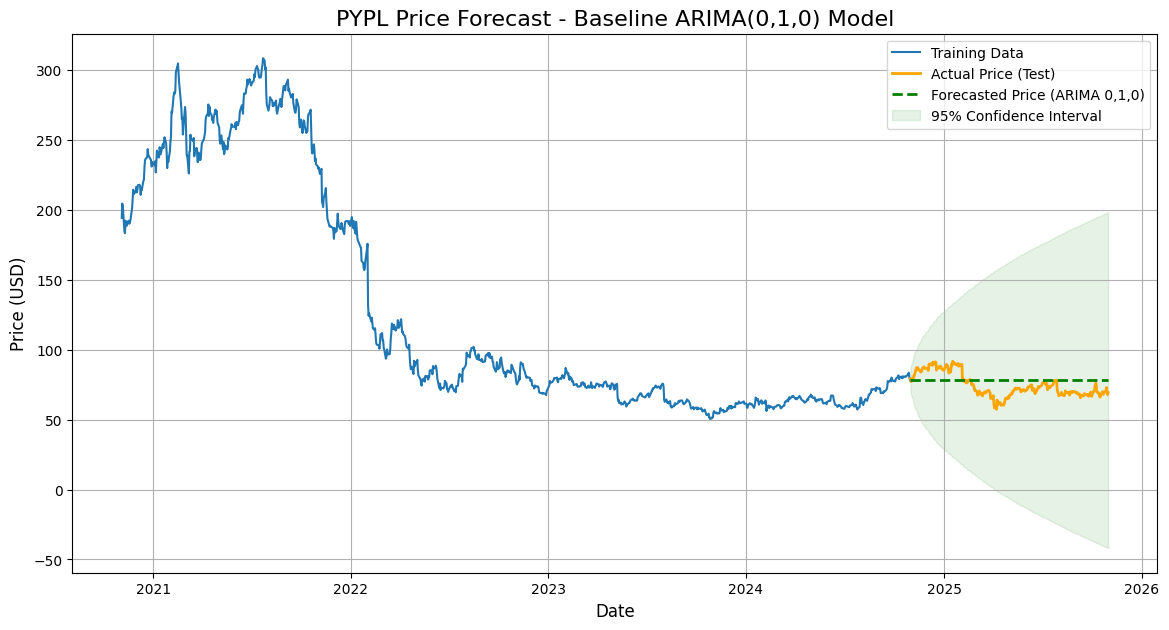

In [10]:
# --- Phase 3: Model Selection & Training (Baseline Model) ---

# We'll build our baseline model: ARIMA(0, 1, 0), the "Random Walk".
# This model predicts that the next price will be the same as the current price.
# We will fit it on the raw 'Close' price, as the 'd=1' handles differencing.

import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# (This code assumes 'data' is the DataFrame from the previous steps)

try:
    # 1. Prepare Data
    # We will use the 'Close' price series
    price_series = data['Close']

    # 2. Split Data into Train (80%) and Test (20%)
    split_point = int(len(price_series) * 0.8)
    train_data = price_series[0:split_point]
    test_data = price_series[split_point:]

    print(f"Total data points: {len(price_series)}")
    print(f"Training data points: {len(train_data)}")
    print(f"Test data points: {len(test_data)}")
    print("\n--- Model Training ---")
    print("Training ARIMA(0, 1, 0) model... (This may take a moment)")

    # 3. Define and Train the ARIMA(0, 1, 0) Model
    # We fit the model on the TRAINING data
    # order=(p, d, q)
    model_order = (0, 1, 0)
    arima_model = ARIMA(train_data, order=model_order)

    # .fit() returns a "results" object
    model_fit = arima_model.fit()

    print(model_fit.summary())
    print("\n--- Model Forecasting ---")

    # 4. Generate Forecasts
    # We want to forecast for the same number of steps as our test set
    num_forecast_steps = len(test_data)

    # get_forecast() predicts the values
    forecast_result = model_fit.get_forecast(steps=num_forecast_steps)

    # Get the predicted mean values
    forecast = forecast_result.predicted_mean
    # Get the confidence intervals (for a nice plot)
    conf_int = forecast_result.conf_int(alpha=0.05) # 95% confidence

    # Set the index of our forecast to match the test data's index
    forecast.index = test_data.index
    conf_int.index = test_data.index

    # 5. Evaluate the Model
    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(test_data, forecast))
    print(f"\nModel RMSE (Root Mean Squared Error): {rmse:.4f}")

    # For context, let's print the mean of the test data
    print(f"Average 'Close' price in test set: {test_data.mean():.4f}")
    print("RMSE tells us the average error of our prediction in USD.")

    # 6. Plot the Results
    print("\n--- Generating Forecast Plot ---")
    plt.figure(figsize=(14, 7))

    # Plot training data
    plt.plot(train_data.index, train_data, label='Training Data')
    # Plot test data
    plt.plot(test_data.index, test_data, label='Actual Price (Test)',
             color='orange', linewidth=2)
    # Plot forecasted data
    plt.plot(forecast.index, forecast, label='Forecasted Price (ARIMA 0,1,0)',
             color='green', linestyle='--', linewidth=2)

    # Plot confidence interval
    plt.fill_between(conf_int.index,
                     conf_int.iloc[:, 0],
                     conf_int.iloc[:, 1],
                     color='green', alpha=0.1, label='95% Confidence Interval')

    plt.title('PYPL Price Forecast - Baseline ARIMA(0,1,0) Model', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price (USD)', fontsize=12)
    plt.legend()
    plt.grid(True)

    # Save the plot
    plt.savefig('pypl_baseline_forecast.png', dpi=300, bbox_inches='tight')
    print("Saved plot to pypl_baseline_forecast.png")

    plt.show()

except ImportError:
    print("Error: 'statsmodels' or 'sklearn' library not found.")
    print("Please install it in Colab by running: !pip install statsmodels scikit-learn")
except Exception as e:
    print(f"An error occurred: {e}")
